In [1]:
import os
from glob import glob
from dataset import (
    KittiGraphDataset,
    MultipleSequenceGraphDataset,
    KittiSequenceDataset,
)
from torch_geometric.loader import DataLoader
from scipy.spatial.transform import Rotation as R
import torch
from tqdm import tqdm
from model import PoseGNN, PoseLoss
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
os.makedirs("models", exist_ok=True)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Using device:", device)

Using device: cuda


In [3]:
basedir = "/home/pcktm/inzynierka/kitti/dataset"
train_sequences = ["00", "01", "02", "03", "04", "05", "06", "07", "08"]

In [4]:
def normalize_position_and_rotation_to_previous(nodes, edge_index, y: list[torch.tensor]) -> tuple:
    # position and rotation are encoded [x, y, z, w, x, y, z] and samples is a list of such vectors
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the frame before it, so that the first frame is always [0, 0, 0]
    new_pos = [positions[0] - positions[0]]
    for i in range(1, positions.shape[0]):
        new_pos.append(positions[i] - positions[i - 1])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the frame before it
    new_rot = [R.from_quat(rotations[0]).inv() * R.from_quat(rotations[0])]
    for i in range(1, rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[i - 1]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [5]:
def normalize_position_and_rotation_to_first(nodes, edge_index, y):
    positions = torch.stack([s[:3] for s in y])
    rotations = torch.stack([s[3:] for s in y])

    # normalize position of each frame to the first frame
    new_pos = []
    for i in range(positions.shape[0]):
        new_pos.append(positions[i] - positions[0])

    new_pos = torch.stack(new_pos)

    # normalize rotation to the first frame
    new_rot =  []
    for i in range(rotations.shape[0]):
        new_rot.append(R.from_quat(rotations[i]).inv() * R.from_quat(rotations[0]))

    new_rot = torch.tensor([r.as_quat() for r in new_rot], dtype=torch.float32)

    return nodes, edge_index, torch.concatenate((new_pos, new_rot), axis=1)

In [8]:
from torch_geometric.utils import dropout_edge

def transformEdgeDropout(nodes, edge_index, y):
    edge_index, _ = dropout_edge(edge_index, p=0.5)
    return nodes, edge_index, y

In [6]:
from dataset import KittiGraphDatasetWithGraphBasedOnVectorDistance


dataset = MultipleSequenceGraphDataset(
    basedir,
    train_sequences,
    dataset=KittiGraphDatasetWithGraphBasedOnVectorDistance,
    transform=normalize_position_and_rotation_to_first,
    graph_length=10,
)
train_dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

model = PoseGNN().to(device)
criterion = PoseLoss(alpha=20)

In [7]:
optimizer = torch.optim.NAdam(model.parameters(), lr=0.001)
MODEL_LETTER = "LINALG_DISTANCE"

os.makedirs(f"models/{MODEL_LETTER}", exist_ok=True)

loss_history = []
for epoch in range(1, 151):
    model.train()
    epoch_loss_history = []
    progress_bar = tqdm(
        train_dataloader, desc=f"Epoch {epoch}", total=len(train_dataloader)
    )
    for batch in progress_bar:
        batch = batch.to(device)
        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch.y)
        loss.backward()
        optimizer.step()
        epoch_loss_history.append(loss.item())
        progress_bar.set_postfix({"loss": loss.item()})
       
    loss_history.append(sum(epoch_loss_history) / len(epoch_loss_history))
    print(f"Epoch {epoch} loss: {sum(epoch_loss_history) / len(epoch_loss_history)}")

    if epoch % 10 == 0:
        torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{MODEL_LETTER}_{epoch}.pth")

torch.save(model.state_dict(), f"models/{MODEL_LETTER}/model_{MODEL_LETTER}_final.pth")

Epoch 1: 100%|██████████| 318/318 [06:20<00:00,  1.20s/it, loss=4.74e+4]


Epoch 1 loss: 67216.32182954992


Epoch 2: 100%|██████████| 318/318 [06:15<00:00,  1.18s/it, loss=9.62e+4]


Epoch 2 loss: 66723.62224228577


Epoch 3: 100%|██████████| 318/318 [06:18<00:00,  1.19s/it, loss=3.93e+4]


Epoch 3 loss: 66184.60128611438


Epoch 4: 100%|██████████| 318/318 [06:14<00:00,  1.18s/it, loss=6.18e+4]


Epoch 4 loss: 108826.25276999803


Epoch 5: 100%|██████████| 318/318 [06:16<00:00,  1.18s/it, loss=7.56e+4]


Epoch 5 loss: 65964.10118784395


Epoch 6: 100%|██████████| 318/318 [06:16<00:00,  1.19s/it, loss=7.91e+4]


Epoch 6 loss: 65020.598135318396


Epoch 7: 100%|██████████| 318/318 [06:18<00:00,  1.19s/it, loss=4.74e+4]


Epoch 7 loss: 63486.210151336476


Epoch 8: 100%|██████████| 318/318 [06:35<00:00,  1.24s/it, loss=2.74e+4]


Epoch 8 loss: 61748.39945705582


Epoch 9: 100%|██████████| 318/318 [07:58<00:00,  1.50s/it, loss=1.92e+4]


Epoch 9 loss: 62705.321602299526


Epoch 10: 100%|██████████| 318/318 [08:04<00:00,  1.52s/it, loss=5.31e+4]


Epoch 10 loss: 61303.697701700075


Epoch 11:  64%|██████▎   | 202/318 [04:33<02:37,  1.35s/it, loss=9.16e+4]


KeyboardInterrupt: 

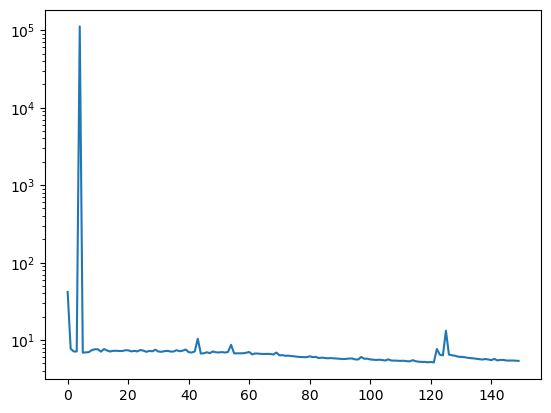

In [ ]:
# plot loss
plt.plot(loss_history)
plt.yscale("log")
plt.show()